In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import zarr
from pyTMD.io import ATLAS
from pyTMD.interpolate import extrapolate #, spline
#from pyTMD.io import read_netcdf_elevation, read_netcdf_transport, read_netcdf_grid #not work for read_netcdf_grid
from datetime import datetime
import netCDF4, pathlib


In [2]:
from src.model_utils import *
from src.model_plot import *
from src.pytmd_utils import * #extend_array, extend_matrix #Note that read_xxx changed to use lib

In [7]:
# Unload the module if needed
import importlib, sys
if 'src.model_utils' in sys.modules:
    print("Module in it!")
    #del sys.modules['src.model_utils']
    importlib.reload(sys.modules['src.model_utils']) 

from src.model_utils import *

Module in it!


In [3]:
# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5'
tpxo9_atlas_v5 = get_tide_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)
print(tpxo9_atlas_v5.grid_file)

/home/bioer/python/tide/data_src/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc


In [4]:
#if tpxo9_atlas_v5:
model_files= tpxo9_atlas_v5.model_file
#print(model_files)
#for i, model_file in enumerate(model_files):
model_file = pathlib.Path(model_files[7]).expanduser()
#model_file = pathlib.Path(model_file).expanduser()
hcz, cons = read_netcdf_elevation(model_file, compressed=False)
#print(hcz.mask.shape)
print(np.where(hcz.mask))

(array([], dtype=int64), array([], dtype=int64))


(array([   0,    0,    0, ..., 5211, 5211, 5211]), array([   0,    1,    2, ..., 9518, 9519, 9520]))


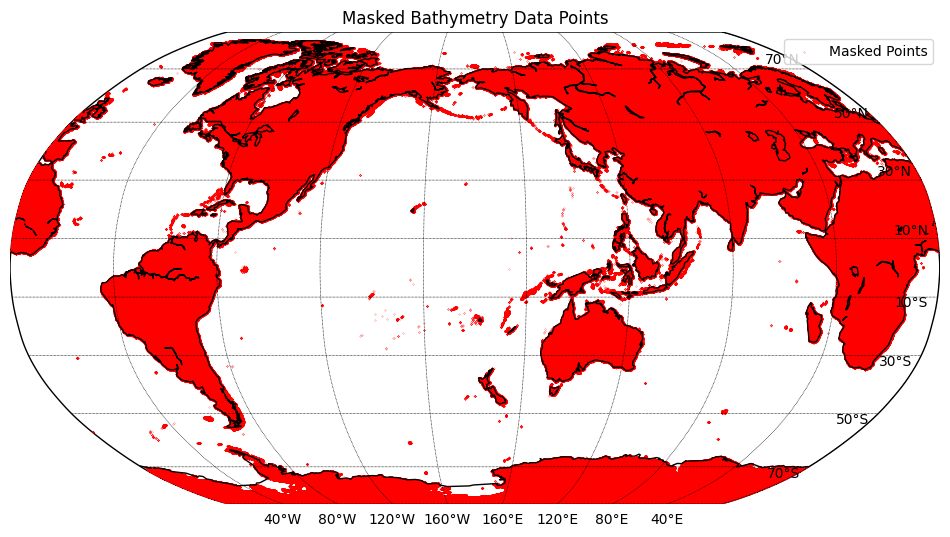

In [50]:
#Check model file NA value location
tmp_mask = np.copy(hcz.mask)
tmp_mask[hcz.data==0j] = True
print(np.where(tmp_mask))
plot_model_mask(tmp_mask)

In [5]:
#I don't know why it's not work by directly import from pyTMD lib.
# TypeError: read_netcdf_grid() got an unexpected keyword argument 'variable'
lonz, latz, bathy_z = read_netcdf_grid(tpxo9_atlas_v5.grid_file, variable='z')
print(lonz)
print(latz)
print(lonz.shape)
print(latz.shape)
print(bathy_z.shape)

[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
(10800,)
(5401,)
(5401, 10800)


In [ ]:
""" #read_netcdf_grid in ATLAS.py
fileID = netCDF4.Dataset(tpxo9_atlas_v5.grid_file, 'r')
# read latitude and longitude at z-nodes
lonz = fileID.variables['lon_z'][:].copy()
latz = fileID.variables['lat_z'][:].copy()
print(lonz)
print(latz)
print(lonz.shape)
print(latz.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)

bathy_z = np.ma.zeros((ny,nx))
bathy_z.data[:,:] = fileID.variables['hz'][:,:].T
bathy_z.mask = (bathy_z.data == 0.0)
fileID.close()
"""

In [6]:
def extract_ATLAS(lon, lat, start_lon, end_lon, start_lat, end_lat,
                  tide_model, type, constituents, chunk_num):
    print('model type-chunk is: ', type, '-', chunk_num)
    if type in ['u', 'v']:
        model_files = tide_model.model_file[type]
    else:
        model_files = tide_model.model_file

    lon_chunk = lon[start_lon:end_lon]
    lat_chunk = lat[start_lat:end_lat]
    lon_grid, lat_grid = np.meshgrid(lon_chunk, lat_chunk)

    # if type == 'z':
    #if constituents is None:
    #    constituents = ATLAS.read_constants(
    #        tide_model.grid_file, model_files, type=type, compressed=tide_model.compressed)

    amp, ph, D = ATLAS.interpolate_constants(
        lon_grid.ravel(), lat_grid.ravel(),
        constituents, type=type, scale=tide_model.scale,
        method='spline', extrapolate=True)
    # else:
    #    amp, ph, D, constituents = ATLAS.extract_constants(
    #        lon_grid.ravel(), lat_grid.ravel(),
    #        tide_model.grid_file,
    #        model_files, type=type, method='spline',
    #        scale=tide_model.scale, compressed=tide_model.compressed)
    #c = ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1',
    #     's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
    chunkx = end_lon - start_lon  # slicing is not include end_lon
    chunky = end_lat - start_lat
    amplitude = np.reshape(amp, (chunky, chunkx, len(constituents)))
    phase = np.reshape(ph, (chunky, chunkx, len(constituents)))
    return amplitude, phase #, constituents

In [7]:
def save_to_zarr(amplitude, phase, constituents, amp_var, ph_var, lon, lat, output_file, group_name, mode='write_chunk'):
    # Check if the group exists in the Zarr file
    if mode == 'append_chunk':
        ds = xr.open_zarr(output_file, group=group_name)
        
        # Append new data variables
        ds[amp_var] = (['lat', 'lon', 'constituents'], amplitude)
        ds[ph_var] = (['lat', 'lon', 'constituents'], phase)
    else:    
    #except ValueError:  # If group does not exist, create a new dataset 
        ds = xr.Dataset({
            amp_var: (['lat', 'lon', 'constituents'], amplitude),
            ph_var: (['lat', 'lon', 'constituents'], phase)
        }, coords={
            'lon': lon,
            'lat': lat,
            'constituents': np.array(constituents, dtype=str)
        })

    ds.to_zarr(output_file, mode='a', group=group_name) 

def tpxo2zarr(lon, lat, bathymetry, amp_var, ph_var, tpxo_model, 
              chunk_size_lon=45, chunk_size_lat=45, grid_sz=1/30, 
              chunk_file='chunks.zarr', type=None, mode='write_chunk', 
              global_grid=False, en_interpolate=False, interpolate_to=None,
              constituents=None):
    if (global_grid):
        lon_range = range(0, len(lon), int(chunk_size_lon/grid_sz))
        lon_range = list([x + 1 for x in lon_range]) 
    else: 
        lon_range = list(range(0, len(lon), int(chunk_size_lon/grid_sz)))
        if len(lon) not in lon_range:  # Ensure last element is included if it's not already
            lon_range.append(len(lon))

    lat_range = range(0, len(lat), int(chunk_size_lat/grid_sz))
    lat_range = list([x + 1 if x==5400 else x for x in lat_range]) #lat length is 5401 not 5400
    if len(lat) not in lat_range:  
        lat_range.append(len(lat))

    cnt_chunk = 0
    # if no chunk in longitude
    # start_lon = 1 if global_grid else 0 # extend_array will also extend first index
    # end_lon = len(lon)-1 if global_grid else len(lon) #chunk lon[0:100] will not include 100, but here lon is expand_array:10801 so do len(lon)-1
    # loop over each chunk
    for lat_idx in range(len(lat_range) - 1):
        for lon_idx in range(len(lon_range) -1):
            start_lon = lon_range[lon_idx] #handle in lon_range #lon_range[lon_idx]+1 if global_grid else lon_range[lon_idx]
            end_lon = lon_range[lon_idx+1] #handle in lon_range #lon_range[lon_idx+1]+1 if global_grid else lon_range[lon_idx+1]
            start_lat, end_lat = lat_range[lat_idx], lat_range[lat_idx+1]      
            print(lon[start_lon], lon[end_lon-1], lat[start_lat], lat[end_lat-1], cnt_chunk)
            # Extract amplitude and phase for the current chunk
            amp_chunk, ph_chunk = extract_ATLAS(lon, lat, start_lon, end_lon, start_lat, end_lat, #bathymetry, 
                                                tpxo_model, type,
                                                constituents, cnt_chunk) #, global_grid, en_interpolate, interpolate_to)
            amp_chunk[amp_chunk.mask] = np.nan
            ph_chunk[ph_chunk.mask] = np.nan
            amp = amp_chunk.data
            ph = ph_chunk.data

            if en_interpolate and interpolate_to is not None:
                glon, glat, gbathy = interpolate_to
                if global_grid:
                    lon_chunk = glon[(start_lon-1):(end_lon-1)] 
                else:
                    lon_chunk = glon[start_lon:end_lon]
                lat_chunk = glat[start_lat:end_lat]
            else:
                lon_chunk = lon[start_lon:end_lon]
                lat_chunk = lat[start_lat:end_lat]
            
            group_name = f"chunk_{cnt_chunk}"
            c = ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1',
                 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
            save_to_zarr(amp, ph, c, amp_var, ph_var, lon_chunk, lat_chunk, chunk_file, group_name, mode)
            cnt_chunk += 1

    return cnt_chunk    
                

In [8]:
# Adjust longitude and lat values as per convention
lonzx = lonz #already in [0,360] # adjust_lon_lat(lonz, lonz)
    
# Determine if it's a global grid
dlon = lonzx[1] - lonzx[0]
global_grid = True # np.isclose(lonzx[-1] - lonzx[0], 360.0 - dlon)
if global_grid:
    lonzx = extend_array(lonzx, dlon)
    bathy_zx = extend_matrix(bathy_z)
    
# create masks
bathy_zx.mask = (bathy_zx.data == 0)

#lon_grid, lat_grid = np.meshgrid(lonzx, latz)
#Dz = spline_2d(lonzx, latz, bathy_zx, lon_grid, lat_grid, reducer=np.ceil, kx=1, ky=1)
print(len(lonz))
print(bathy_z.shape)
print('----after extend----')
print(len(lonzx))
print(bathy_zx.shape)

10800
(5401, 10800)
----after extend----
10802
(5401, 10802)


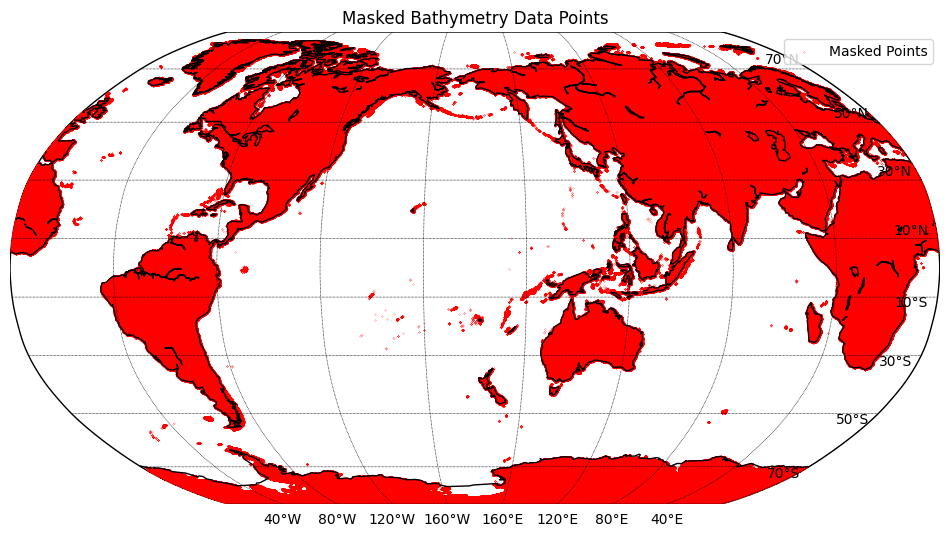

In [14]:
plot_model_mask(bathy_zx[:,1:10801].mask)

In [9]:
#Global variable 
global_grid = False #True
xChunkSz = 15
yChunkSz = 15
grid_sz = 1/30
chunk_file = 'tpxo9_chunks.zarr'

In [10]:
#Global variable Test
print(lonz[5398:5402]) #try chunk not crossing 180 degree to avoid interpolation error??
print(latz[2698:2702])

lon_range = list(range(0, len(lonz), int(xChunkSz/grid_sz)))
##lon_range = list([x - 1 for x in lon_range]) # to not crossing 180 #slicing not include end
if len(lonz) not in lon_range:  # Ensure last element is included if it's not already
    lon_range.append(len(lonz))
print(lon_range)

lat_range = range(0, len(latz), int(yChunkSz/grid_sz))
lat_range = list([x + 1 if x==5400 else x for x in lat_range]) #lat length is 5401 not 5400
if len(latz) not in lat_range: 
    lat_range.append(len(latz))
print(lat_range)

lon_extend = range(0, len(lonzx), int(xChunkSz/grid_sz))
lon_extend = list([x + 1 for x in lon_extend]) 
#if len(lonzx) not in lon_extend:  
#    lon_extend.append(len(lonzx))
print(lon_extend)
print([lonzx[x] for x in lon_extend])
print(lonz[0], lonz[-1])

[179.96666463 179.99999797 180.0333313  180.06666463]
[-0.06666667 -0.03333333  0.          0.03333333]
[0, 450, 900, 1350, 1800, 2250, 2700, 3150, 3600, 4050, 4500, 4950, 5400, 5850, 6300, 6750, 7200, 7650, 8100, 8550, 9000, 9450, 9900, 10350, 10800]
[0, 450, 900, 1350, 1800, 2250, 2700, 3150, 3600, 4050, 4500, 4950, 5401]
[1, 451, 901, 1351, 1801, 2251, 2701, 3151, 3601, 4051, 4501, 4951, 5401, 5851, 6301, 6751, 7201, 7651, 8101, 8551, 9001, 9451, 9901, 10351, 10801]
[0.033333334014147384, 15.033333164435826, 30.033332994857506, 45.03333282527918, 60.03333265570086, 75.03333248612255, 90.03333231654422, 105.0333321469659, 120.03333197738758, 135.03333180780928, 150.03333163823095, 165.03333146865262, 180.03333129907432, 195.033331129496, 210.03333095991766, 225.03333079033936, 240.03333062076103, 255.0333304511827, 270.0333302816044, 285.0333301120261, 300.0333299424477, 315.0333297728694, 330.0333296032911, 345.03332943371277, 360.03332926413447]
0.033333334014147384 359.99999593117

In [12]:
if False: #global_grid: #bathymetry_z need not interpolate
    bathy = bathy_zx
    lonx = lonzx
    #lat_chunk = yChunkSz
    en_interpolate = True
else: 
    bathy = bathy_z
    lonx = lonz
    #lat_chunk = 180 #must sync with u, v
    en_interpolate = False
print(bathy.shape)
percentiles = [1, 10, 25, 30, 40, 50, 75, 90, 99]
mvalues = np.percentile(bathy.data, percentiles)

# Print the results
for p, v in zip(percentiles, mvalues):
    print(f"{p}th percentile: {v}")

smallz_indx = np.where((bathy.data < 1.0316635131838137*10) & (bathy.data > 0))
print(bathy.data[smallz_indx].shape)
#print(bathy.data[smallz_indx])


(5401, 10800)
1th percentile: 0.0
10th percentile: 0.0
25th percentile: 0.0
30th percentile: 0.0
40th percentile: 253.1468383789063
50th percentile: 2515.1793212890625
75th percentile: 4281.35986328125
90th percentile: 5062.09033203125
99th percentile: 5824.58056640625
(222781,)


In [23]:
#constituents = ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1',
#                's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']

constituents = ATLAS.read_constants(
            tpxo9_atlas_v5.grid_file, model_files, type='z', 
            compressed=tpxo9_atlas_v5.compressed)
print(constituents)

q1, o1, p1, k1, n2, m2, s1, s2, k2, m4, ms4, mn4, 2n2, mf, mm


In [15]:
#conu = ATLAS.read_constants(
#            tpxo_curr_model.grid_file, tpxo_curr_model.model_file['u'], type='u', 
#            compressed=tpxo_curr_model.compressed)
#print(conu)


q1, o1, p1, k1, n2, m2, s1, s2, k2, m4, ms4, mn4, 2n2, mf, mm


In [29]:
#print(len(conu))

15


In [ ]:
# Doing bathy_z need not interpolate, but lat_chunk must sync with doing u, v
# must rm -rf xx_chunks.zarr/

chunkz = tpxo2zarr(lonz, latz, bathy_z, 'h_amp', 'h_ph',  tpxo9_atlas_v5, 
                   xChunkSz, yChunkSz, grid_sz=1/30, chunk_file=chunk_file, 
                   type='z', mode='write_chunk', global_grid=False, 
                   en_interpolate=False, interpolate_to=None,
                   constituents=constituents)
print(chunkz)

In [11]:
#Temporarily test, concate by lat axis, if no chunks in lon axis
# ds_combined = xr.concat([xr.open_zarr(chunkz_file, group=f"chunk_{i}") for i in range(chunkz)], dim='lat')
# chunk_size = 338
# ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
# ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)

# This approach assumes that each chunk has the same size, except perhaps the last one in each dimension. It takes the chunks, organizes them in their proper 2D sequence, and then concatenates them in the correct order.
num_lat_chunks = len(lat_range) - 1
num_lon_chunks = len(lon_range) - 1

# 1. Organize the chunks into a 2D matrix
chunks_matrix = [[xr.open_zarr(chunk_file, group=f"chunk_{lat_idx*num_lon_chunks + lon_idx}") 
                  for lon_idx in range(num_lon_chunks)] 
                  for lat_idx in range(num_lat_chunks)]

# 2. Concatenate the chunks

# Concatenate chunks along the longitude for each latitude band
concat_along_lon = [xr.concat(lon_chunks, dim='lon') for lon_chunks in chunks_matrix]

# Now, concatenate the results along the latitude
ds_combined = xr.concat(concat_along_lon, dim='lat')

chunk_size = 338
ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)


In [12]:
dz = xr.open_zarr('tpxo9.zarr', chunks='auto', decode_times=False)
print(dz)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    z_amp         (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>


In [23]:
#TPXO9_atlas_v5
ilon = 335 #122.26672
ilat = 30 #23.76175
#grid_sz = 1/30

dsub = dz.sel(lon=slice(ilon, ilon+5), lat=slice(ilat, ilat+5))
print(dsub)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 150, lon: 150)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 30.0 30.03 30.07 30.1 ... 34.87 34.9 34.93 34.97
  * lon           (lon) float64 335.0 335.1 335.1 335.1 ... 339.9 340.0 340.0
Data variables:
    z_amp         (lat, lon, constituents) float64 dask.array<chunksize=(16, 7, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 dask.array<chunksize=(16, 7, 8), meta=np.ndarray>


In [11]:
start_date = datetime(2023, 7, 25)
end_date = datetime(2023, 7, 28)


tide_time, dtime = get_tide_time(start_date, end_date)
print(tide_time.shape)
print(tide_time)

(73,)
[11528.         11528.04166667 11528.08333333 11528.125
 11528.16666667 11528.20833333 11528.25       11528.29166667
 11528.33333333 11528.375      11528.41666667 11528.45833333
 11528.5        11528.54166667 11528.58333333 11528.625
 11528.66666667 11528.70833333 11528.75       11528.79166667
 11528.83333333 11528.875      11528.91666667 11528.95833333
 11529.         11529.04166667 11529.08333333 11529.125
 11529.16666667 11529.20833333 11529.25       11529.29166667
 11529.33333333 11529.375      11529.41666667 11529.45833333
 11529.5        11529.54166667 11529.58333333 11529.625
 11529.66666667 11529.70833333 11529.75       11529.79166667
 11529.83333333 11529.875      11529.91666667 11529.95833333
 11530.         11530.04166667 11530.08333333 11530.125
 11530.16666667 11530.20833333 11530.25       11530.29166667
 11530.33333333 11530.375      11530.41666667 11530.45833333
 11530.5        11530.54166667 11530.58333333 11530.625
 11530.66666667 11530.70833333 11530.75       11

In [25]:
print(dsub["z_amp"].values.shape)
print(dsub["z_ph"].values.shape)
print(dsub["z_amp"].isel(lon=0, lat=0).values)
print(dsub["z_ph"].isel(lon=0, lat=0).values)
#print(c)

(150, 150, 15)
(150, 150, 15)
[0.01029563 0.03046309 0.01204159 0.0417732  0.08228001 0.39824866
 0.00316228 0.16570154 0.04742362 0.00223607 0.00141421 0.
 0.00824621 0.006      0.00223607]
[240.94540412 293.19859158  41.63354103  47.91083663  20.63754635
  31.65462782 341.56505135  51.1241845   47.56377081  26.56505089
 135.00000034  -0.         345.96375635  -0.         333.43494911]


In [26]:
tide_level = get_tide_series(dsub['z_amp'].isel(lon=0, lat=0).values,
                    dsub['z_ph'].isel(lon=0, lat=0).values,
                    dsub.coords['constituents'].values, tide_time)

In [27]:
print(tide_level.data, max(tide_level.data), min(tide_level.data))

[ 62.43303981  68.35218139  79.94964815  94.31490454 107.83443051
 117.0332625  119.54002011 114.83545124 104.43276271  91.37442876
  79.26564273  71.25874501  69.3330899   73.97592108  84.17620317
  97.62864252 111.14992918 121.35781111 125.55014938 122.52323953
 112.97889013  99.31025791  84.85476911  72.94681053  66.12616916
  65.67974298  71.48945678  82.09203109  94.9317118  106.86433768
 114.9148631  117.1133048  113.09207231 104.17329804  92.90834245
  82.29200729  74.97796692  72.72190176  76.09363675  84.39494424
  95.75449312 107.45430801 116.53406796 120.57997568 118.43921956
 110.56506748  98.84994503  86.04621943  75.03561015  68.19220303
  66.94567731  71.53275759  80.91856952  92.9376231  104.72708805
 113.42840206 116.96865165 114.6363494  107.23257022  96.77341673
  85.90741022  77.27208377  72.94254879  74.02032516  80.37473662
  90.5902676  102.2075814  112.28809443 118.18702086 118.28734047
 112.434939   101.94271618  89.21254197] 125.55014937548702 62.4330398051205

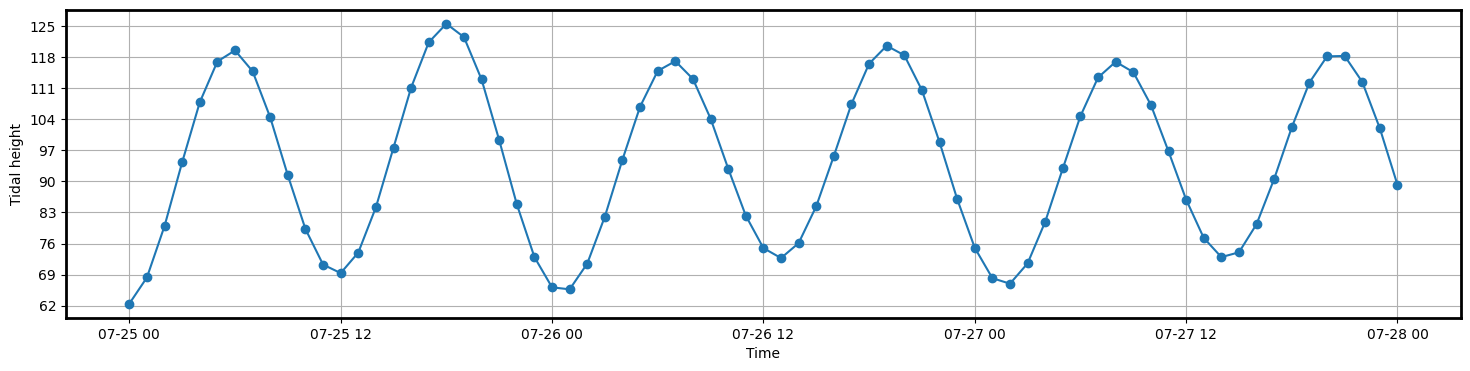

In [28]:
plot_tide_level(tide_level, dtime)

In [12]:
# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5'

tpxo_curr_model = get_current_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)

In [24]:
print(tpxo_curr_model)
print(tpxo_curr_model.grid_file)
print(tpxo_curr_model.model_file)

/home/bioer/python/tide/data_src/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc
{'u': [PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data

In [ ]:
#if tpxo_curr_model:
model_files= tpxo_curr_model.model_file["u"]
print(model_files)
model_file = pathlib.Path(model_files[0]).expanduser()
hcx, cons = read_netcdf_transport(model_file, variable="u", compressed=False)
print(hcx.shape)
print(hcx)
print(hcx.mask)
tmp_mask = np.copy(hcx.mask)
tmp_mask[hcx.data==0j] = True
print(np.where(tmp_mask))

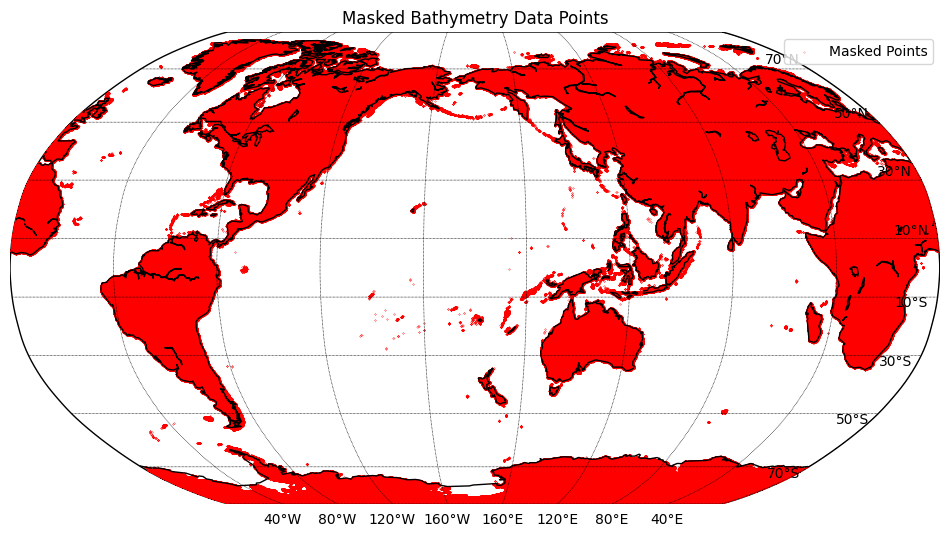

In [690]:
plot_model_mask(tmp_mask)

In [27]:
lonu, latu, bathy_u = read_netcdf_grid(tpxo_curr_model.grid_file, variable='u')
print(lonu)
print(latu)
print(lonu.shape)
print(latu.shape)
print(bathy_u.shape)

[1.66666675e-02 5.00000005e-02 8.33333334e-02 ... 3.59916663e+02
 3.59949996e+02 3.59983329e+02]
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
(10800,)
(5401,)
(5401, 10800)


In [ ]:
"""
#read_netcdf_grid in ATLAS.py
#import netCDF4
fileID = netCDF4.Dataset(tpxo_curr_model.grid_file, 'r')
# read latitude and longitude at z-nodes
lonu = fileID.variables['lon_u'][:].copy()
latu = fileID.variables['lat_u'][:].copy()
print(lonu)
print(latu)
print(lonu.shape)
print(latu.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)
bathy_u = np.ma.zeros((ny,nx))
bathy_u.data[:,:] = fileID.variables['hu'][:,:].T
bathy_u.mask = (bathy_u.data == 0.0)
"""

In [26]:
# Adjust longitude and lat values as per convention
lonux = np.copy(lonu) #already in [0,360] # adjust_lon_lat(lonu, lonu)
    
# Determine if it's a global grid
dlon = lonux[1] - lonux[0]
#global_grid = np.isclose(lonux[-1] - lonux[0], 360.0 - dlon)
print(global_grid)
if global_grid:
    lonux = extend_array(lonux, dlon)
    bathy_ux = extend_matrix(bathy_u)
    
# create masks
bathy_ux.mask = (bathy_ux.data == 0)

#lon_grid, lat_grid = np.meshgrid(lonux, latu)
#Du = spline_2d(lonux, latu, bathy_ux, lon_grid, lat_grid, reducer=np.ceil, kx=1, ky=1)
print(bathy_ux.shape)


True
(5401, 10802)


In [582]:
#check value in bbox (-25, 25, -20, 30) => 335-340, 25-30 that has no values in u,v
pu = bathy_u[3450:3600, 10050:10200]
print(np.where(np.isnan(pu)))
print(np.where(pu.mask))
print(np.where(bathy_u.mask))


(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([   0,    0,    0, ..., 5209, 5209, 5209]), array([   0,    1,    2, ..., 9823, 9824, 9825]))
(array([   0,    0,    0, ..., 5209, 5209, 5209]), array([   0,    1,    2, ..., 9824, 9825, 9826]))


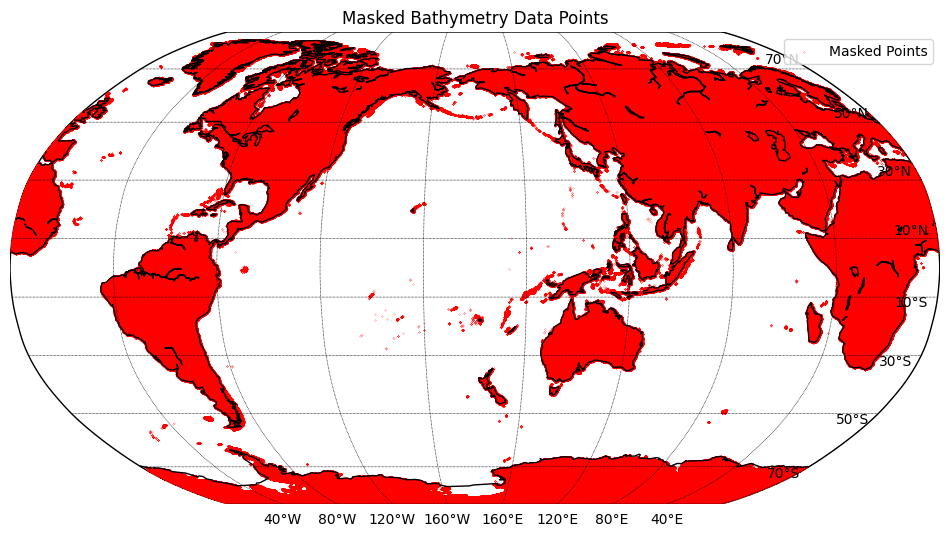

In [590]:
plot_model_mask(bathy_u.mask)

In [156]:
tolerance = 1e-9
def allIdentical(x, y, tolerance=1e-9):
    # Check if lon_u and lon_v are almost equal element-wise within the tolerance
    identicalx = np.allclose(x, y, atol=tolerance)

    if identicalx:
        print("The arrays are identical.")
        return None
    else:
        print("The arrays are not identical.")
        not_identical_mask = np.abs(x - y) > tolerance
        # Find the indices of elements that are not identical
        return np.where(not_identical_mask)

In [157]:
nlonidx = allIdentical(lonz, lonu)
nlatidx = allIdentical(latz, latu)
print(lonz[nlonidx])
print(lonu[nlonidx])

The arrays are not identical.
The arrays are identical.
[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[1.66666675e-02 5.00000005e-02 8.33333334e-02 ... 3.59916663e+02
 3.59949996e+02 3.59983329e+02]


In [28]:
lonv, latv, bathy_v = read_netcdf_grid(tpxo_curr_model.grid_file, variable='v')
print(lonv)
print(latv)
print(lonv.shape)
print(latv.shape)
print(bathy_v.shape)

[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[-90.01667023 -89.98333689 -89.95000356 ...  89.91667022  89.95000356
  89.98333689]
(10800,)
(5401,)
(5401, 10800)


In [ ]:
"""
fileID = netCDF4.Dataset(tpxo_curr_model.grid_file, 'r')
# read latitude and longitude at z-nodes
lonv = fileID.variables['lon_v'][:].copy()
latv = fileID.variables['lat_v'][:].copy()
print(lonv)
print(latv)
print(lonv.shape)
print(latv.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)
bathy_v = np.ma.zeros((ny,nx))
bathy_v.data[:,:] = fileID.variables['hv'][:,:].T
bathy_v.mask = (bathy_v.data == 0.0)
"""

In [158]:
nlonidx = allIdentical(lonu, lonv)
nlatidx = allIdentical(latu, latv)
print(lonu[nlonidx])
print(lonv[nlonidx])
print("--------------------")
print(latu[nlatidx])
print(latv[nlatidx])


The arrays are not identical.
The arrays are not identical.
[1.66666675e-02 5.00000005e-02 8.33333334e-02 ... 3.59916663e+02
 3.59949996e+02 3.59983329e+02]
[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
--------------------
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
[-90.01667023 -89.98333689 -89.95000356 ...  89.91667022  89.95000356
  89.98333689]


In [26]:
# must rm -rf xx_chunks.zarr/
# global_grid = False
if global_grid:
    bathy = bathy_ux
    lonx = lonux
    #lat_chunk = 45
    en_interpolate = True
else: 
    bathy = bathy_u
    lonx = lonu
    #lat_chunk = 180
    en_interpolate = False

print(global_grid)
print(en_interpolate)
print(lonx)
print(chunk_file)

True
True
[-1.66666654e-02  1.66666675e-02  5.00000005e-02 ...  3.59949996e+02
  3.59983329e+02  3.60016663e+02]
tpxo9_chunks.zarr


In [27]:
# must rm -rf xx_chunks.zarr/
# check ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
# cp -R tpxo9_chunkz.zarr/ tpxo9_chunks.zarr
# chunk_file = 'tpxo9_chunks.zarr' # setup in aboving global variable section
chunku = tpxo2zarr(lonx, latu, bathy, 'u_amp', 'u_ph',  tpxo_curr_model, 
                   xChunkSz, yChunkSz, grid_sz=1/30, 
                   chunk_file=chunk_file, type='u', mode="append_chunk", global_grid=global_grid,
                   en_interpolate=en_interpolate, interpolate_to=(lonz, latz, bathy_z))
print(chunku)

0.016666667535901077 44.98333282584445 -90.0000035597249 -45.0333351145142 0
model type is:  u
Interpolate to write:  0.033333334014147384 44.999999492322694 -90.0000035597249 -45.0333351145142
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 13

In [28]:
# Adjust longitude and lat values as per convention
lonvx = np.copy(lonv) #already in [0,360] # adjust_lon_lat(lonv, lonv)
    
# Determine if it's a global grid
dlon = lonvx[1] - lonvx[0]
print(global_grid)
#global_grid = np.isclose(lonvx[-1] - lonvx[0], 360.0 - dlon)
if global_grid:
    lonvx = extend_array(lonvx, dlon)
    bathy_vx = extend_matrix(bathy_v)
    
# create masks
bathy_vx.mask = (bathy_vx.data == 0)

#lon_grid, lat_grid = np.meshgrid(lonvx, latv)
#Dv = spline_2d(lonvx, latv, bathy_vx, lon_grid, lat_grid, reducer=np.ceil, kx=1, ky=1)
print(bathy_vx.shape)
#print(Dv)

True
(5401, 10802)


In [579]:
print(np.where(np.isnan(bathy_v)))


(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


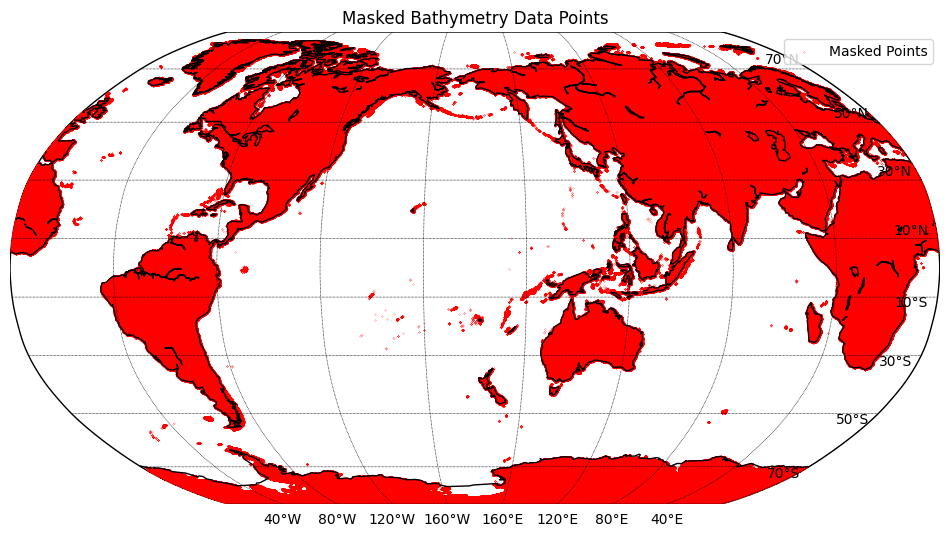

In [592]:
plot_model_mask(bathy_v[:,1:10801].mask)

In [29]:
# must rm -rf xx_chunks.zarr/
# global_grid = False
if global_grid:
    bathy = bathy_vx
    lonx = lonvx
    #lat_chunk = 45
    en_interpolate = True
else: 
    bathy = bathy_v
    lonx = lonv
    #lat_chunk = 180
    en_interpolate = False

print(en_interpolate)
print(lonx)

True
[1.05765477e-09 3.33333340e-02 6.66666670e-02 ... 3.59966663e+02
 3.59999996e+02 3.60033329e+02]


In [30]:
#chunk_file = 'tpxo9_chunks.zarr'
chunkv = tpxo2zarr(lonx, latv, bathy, 'v_amp', 'v_ph',  tpxo_curr_model, 
                   xChunkSz, yChunkSz, grid_sz=1/30, 
                   chunk_file=chunk_file, type='v', mode="append_chunk", global_grid=global_grid, 
                   en_interpolate=en_interpolate, interpolate_to=(lonz, latz, bathy_z))
print(chunkv)

0.033333334014147384 44.999999492322694 -90.01667022705078 -45.05000178184007 0
model type is:  v
Interpolate to write:  0.033333334014147384 44.999999492322694 -90.0000035597249 -45.0333351145142
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350, 1350)
---- non_masked_indices: 0
extrapolate:  (1350,

In [25]:
#ds_combined = xr.concat([xr.open_zarr(chunk_file, group=f"chunk_{i}") for i in range(chunkv)], dim='lat')
#chunk_size = 338
#ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
#ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)


# This approach assumes that each chunk has the same size, except perhaps the last one in each dimension. It takes the chunks, organizes them in their proper 2D sequence, and then concatenates them in the correct order.
num_lat_chunks = len(lat_range) - 1
num_lon_chunks = len(lon_range) - 1

# 1. Organize the chunks into a 2D matrix
chunks_matrix = [[xr.open_zarr(chunk_file, group=f"chunk_{lat_idx*num_lon_chunks + lon_idx}") 
                  for lon_idx in range(num_lon_chunks)] 
                  for lat_idx in range(num_lat_chunks)]

# 2. Concatenate the chunks

# Concatenate chunks along the longitude for each latitude band
concat_along_lon = [xr.concat(lon_chunks, dim='lon') for lon_chunks in chunks_matrix]

# Now, concatenate the results along the latitude
ds_combined = xr.concat(concat_along_lon, dim='lat')

chunk_size = 338
ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)

In [26]:
# move tpxo9.zarr to src/ to prevent it been written if do not want change before commit version change
dz = xr.open_zarr('tpxo9.zarr', chunks='auto', decode_times=False)
print(dz)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    u_amp         (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>


In [27]:
x0, y0, x1, y1 = 118.0, 20.0, 129.75, 31.25 
#x0, y0, x1, y1 = 122.26672, 23.76175, 129.75, 31.25 #123.5, 28 #to test v is empty bug 
#x0, y0, x1, y1 = 123.75, 23.76175, 129.75, 31.25
grid_sz = 1/30
uvsub = dz.sel(lon=slice(x0-grid_sz, x1+grid_sz), lat=slice(y0-grid_sz, y1+grid_sz))
#print(uvsub['u_amp'].values)
#print(uvsub['u_ph'].values)


In [28]:
tide_curr = get_tide_map(uvsub, tide_time[0:1])
print(tide_curr)

{'u': masked_array(
  data=[[[23.72593027829161],
         [25.157223797329543],
         [26.646060352055372],
         ...,
         [-41.00181919944255],
         [-41.126158320603615],
         [-41.260785965204605]],

        [[22.157362063894134],
         [23.676802492273527],
         [25.247048927128716],
         ...,
         [-40.88541130157549],
         [-41.019718328949295],
         [-41.15926368278692]],

        [[20.96925901833982],
         [22.475329958982613],
         [24.01451617892337],
         ...,
         [-40.74241811478311],
         [-40.90498343378043],
         [-41.07228971171635]],

        ...,

        [[--],
         [--],
         [--],
         ...,
         [-378.94717870579996],
         [-304.92537633941305],
         [-248.50507414305122]],

        [[--],
         [--],
         [--],
         ...,
         [-450.0165458781292],
         [-367.09003822535476],
         [-297.0294135774241]],

        [[--],
         [--],
         [--],
   

In [29]:
gtide = tide_curr
dsel = uvsub
# Set the time index (0 to 23)
t = 0
nx = dsel.coords['lon'].size
ny = dsel.coords['lat'].size
print(ny, nx)
glon, glat = np.meshgrid(dsel.coords['lon'].values, dsel.coords['lat'].values)

# Reshape u and v to 2D
u0 = gtide['u'][:,:,t]*0.01 #.reshape(ny, nx)
v0 = gtide['v'][:,:,t]*0.01 #.reshape(ny, nx)

# Create a grid of indices for subsetting
# ny, nx = np.shape(lon)
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

# Calculate magnitude of the current
magnitude = np.sqrt(u0**2 + v0**2)
print(magnitude)
print(u0)
print(v0)
# Normalize the arrows to create a uniform arrow size across the plot
u = u0/magnitude
v = v0/magnitude



n = 5
mask = (X % n == 0) & (Y % n == 0)

x = glon[mask]
y = glat[mask]
u = u[mask]
v = v[mask]
mag = magnitude[mask]

340 354
[[0.27471549043335425 0.28871607401176647 0.3032978378576624 ...
  0.41179696105266583 0.4127948678488351 0.4139146221908042]
 [0.2550954087667418 0.26999721408910765 0.28540695579327285 ...
  0.4106984907921697 0.4117940080426226 0.41296060110023736]
 [0.23904734524174004 0.2539784994670493 0.2692139332542061 ...
  0.4093358957160938 0.410713051722804 0.4121553461361102]
 ...
 [-- -- -- ... 3.8955795449170347 3.334105481721837 3.0283191539115273]
 [-- -- -- ... 4.52578209783737 3.809057554097733 3.3286554744970207]
 [-- -- -- ... 4.988160392116875 4.278364767476701 3.6689049814658987]]
[[0.2372593027829161 0.2515722379732954 0.26646060352055373 ...
  -0.4100181919944255 -0.4112615832060362 -0.41260785965204605]
 [0.22157362063894134 0.23676802492273527 0.2524704892712872 ...
  -0.40885411301575486 -0.41019718328949295 -0.41159263682786923]
 [0.2096925901833982 0.22475329958982612 0.2401451617892337 ...
  -0.40742418114783113 -0.4090498343378043 -0.41072289711716353]
 ...
 [-- 

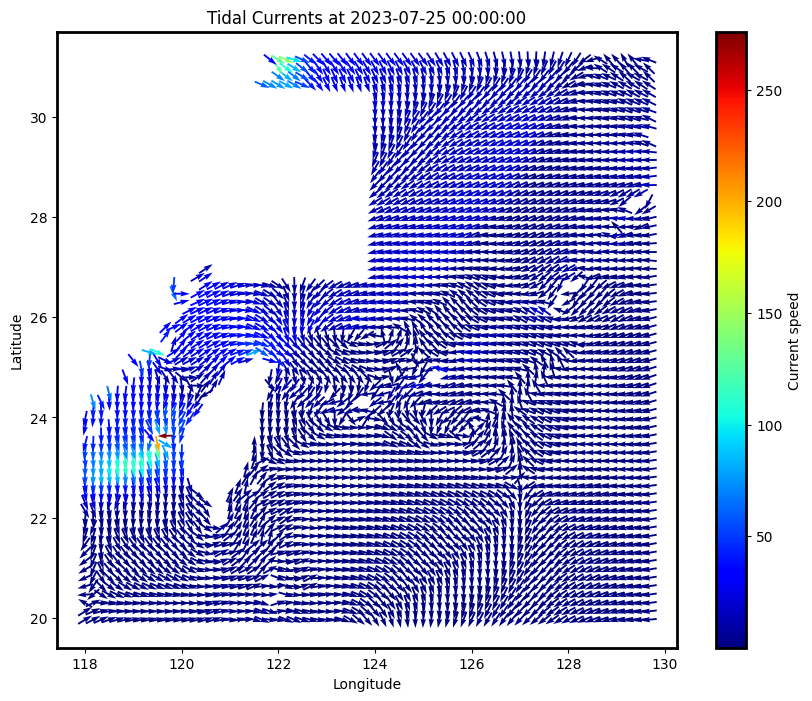

In [30]:
plot_current(x, y, u, v, mag, dtime[0])

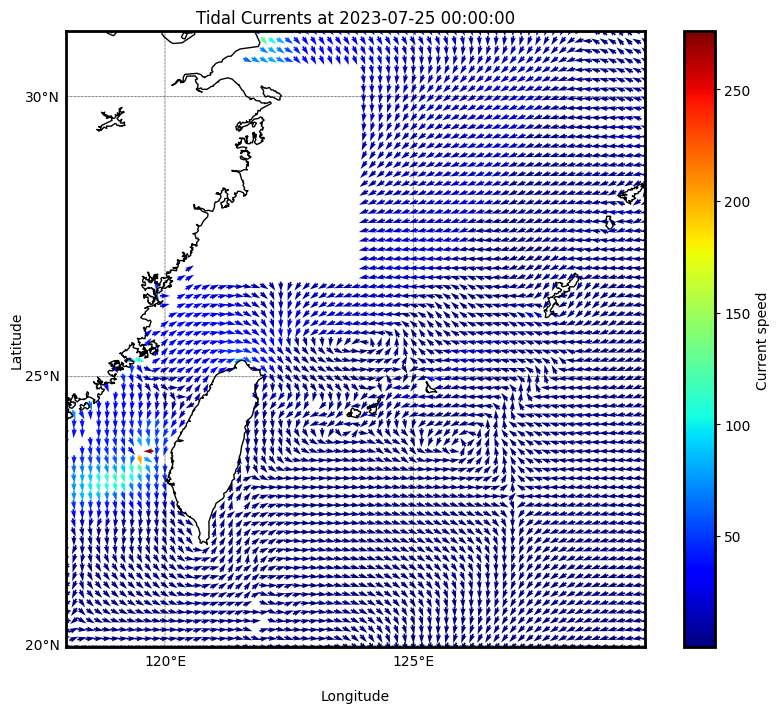

In [31]:
plot_current_map(x, y, u, v, mag, dtime[0])

In [339]:
#just debugging...
subset_lon_values = uvsub.coords['lon'].values
subset_lat_values = uvsub.coords['lat'].values

# Get the original lon and lat values
original_lon_values = dz.coords['lon'].values
original_lat_values = dz.coords['lat'].values

# Find the start and end indices of the subset lon and lat in the original lon and lat
start_lon = np.where(original_lon_values == subset_lon_values[0])[0][0]
end_lon = np.where(original_lon_values == subset_lon_values[-1])[0][0] + 1 # +1 for slice not include end

start_lat = np.where(original_lat_values == subset_lat_values[0])[0][0]
end_lat = np.where(original_lat_values == subset_lat_values[-1])[0][0] + 1
print(start_lon, end_lon, start_lat, end_lat)
#print(bathy_v[start_lat:end_lat, start_lon:end_lon])
print(uvsub["v_amp"].values)
filled = uvsub.interpolate_na(['lon','lat'], method="spline")
print(filled["v_amp"].values)

3644 3766 3374 3586


In [32]:
#North Atlantic
x1, y1, u1, v1, mag1 = get_current_map(280, 0, 360, 60, dz, tide_time[0:1], mask_grid=5)


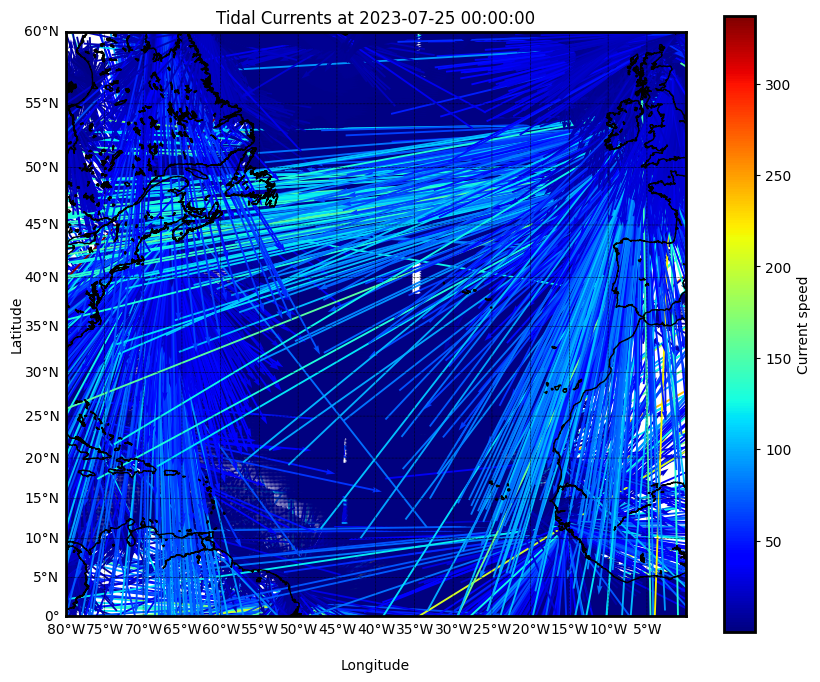

In [33]:
plot_current_map(x1, y1, u1, v1, mag1, dtime[0])

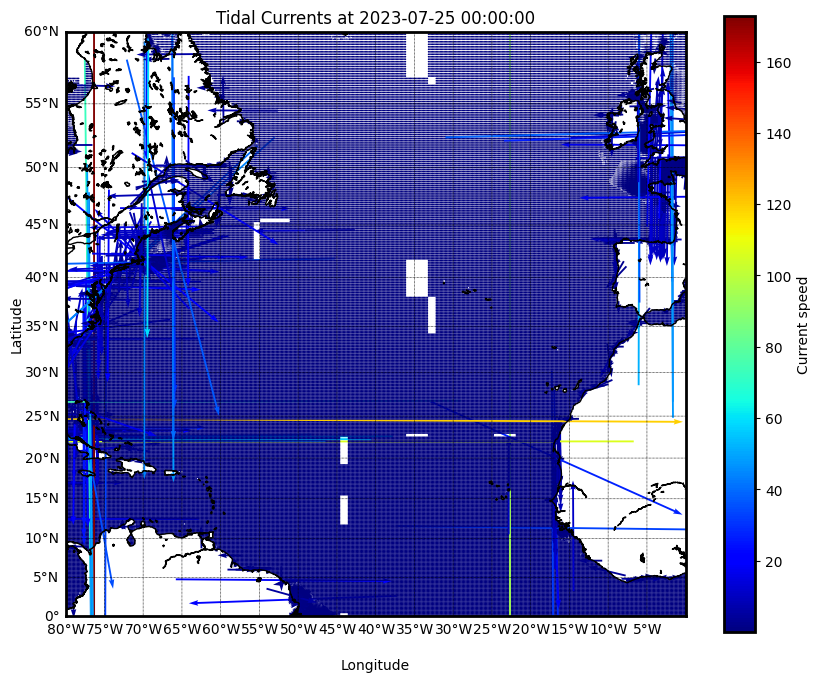

In [34]:
u2 = np.copy(u1)*0.01
v2 = np.copy(v1)*0.01
#mag2 = np.copy(mag1)*0.01
u2[u2>200] = np.nan
v2[v2>200] = np.nan
mag2 = np.sqrt(u2**2 + v2**2)
plot_current_map(x1, y1, u2, v2, mag2, dtime[0])


In [35]:
x1t, y1t, u1t, v1t, mag1t = get_current_map(330, 15, 359.9, 35, dz, tide_time[0:1], mask_grid=10)
print(u1t, v1t, mag1t)

[-0.4434791005757156 -0.43647732876912754 -0.42527473898017826 ... -- --
 --] [0.09407397461668197 0.11790838111858393 0.14766223080084195 ... -- -- --] [0.45334713558996464 0.4521225993770255 0.45018078370776765 ... -- -- --]


In [36]:
print(max(u1t), max(v1t), max(mag1t), np.argmax(mag1t))
tt = np.argmax(mag1t)
print(mag1t[tt])
print(u1t[tt], v1t[tt], np.sqrt(u1t[tt]**2 + v1t[tt]**2))

66.39377476541574 10.994841636275721 69.25101594382211 1389
69.25101594382211
66.39377476541574 -19.686794600715167 69.25101594382211


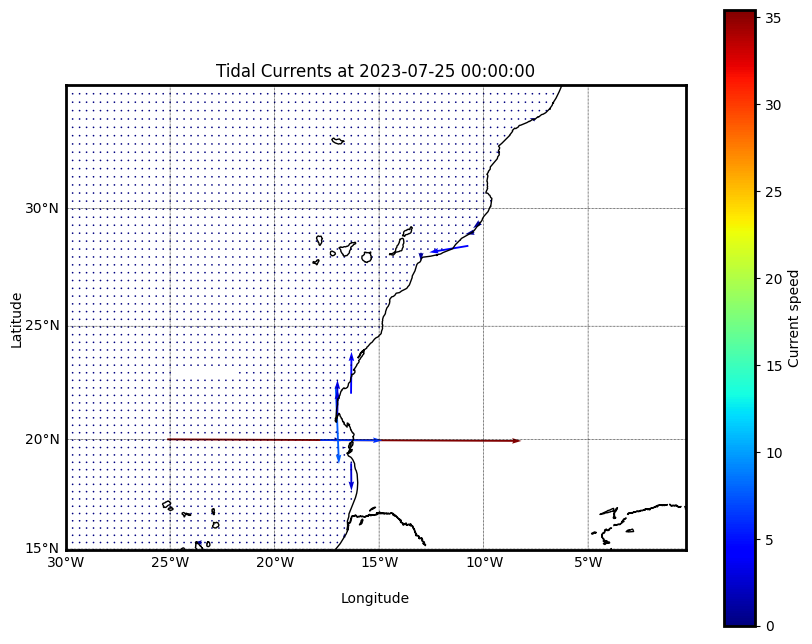

In [37]:
#plot_current(x1t, y1t, u1t, v1t, mag1t, dtime[0])
u2 = np.copy(u1t)*0.01
v2 = np.copy(v1t)*0.01
#mag2 = np.copy(mag1)*0.01
u2[u2>200] = np.nan
v2[v2>200] = np.nan
mag2 = np.sqrt(u2**2 + v2**2)
plot_current_map(x1t, y1t, u2, v2, mag2, dtime[0])

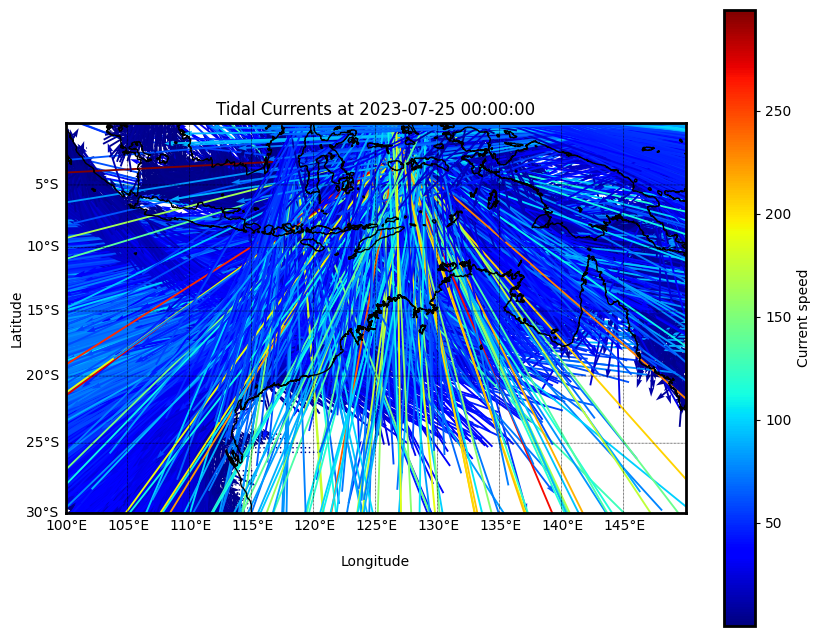

In [24]:
#Indian Ocean
x2, y2, u2, v2, mag2 = get_current_map(100, -30, 150, 0, dz, tide_time[0:1], mask_grid=10)
plot_current_map(x2, y2, u2, v2, mag2, dtime[0])

In [12]:
#Delete v_amp, v_ph chunks as the paralle-work broken suddenly
#import xarray as xr
Confirmed = False
if Confirmed:
    num_lat_chunks = len(lat_range) - 1
    num_lon_chunks = len(lon_range) - 1
    chunk_file = 'tpxo9_chunks.zarr'

    for lat_idx in range(num_lat_chunks):
        for lon_idx in range(num_lon_chunks):
            group_name = f"chunk_{lat_idx * num_lon_chunks + lon_idx}"
            ds_chunk = xr.open_zarr(chunk_file, group=group_name)

            # If the unwanted variables exist in the chunk, drop them
            vars_to_drop = [var for var in ['v_amp', 'v_ph'] if var in ds_chunk.variables]
            if vars_to_drop:
                ds_chunk = ds_chunk.drop_vars(vars_to_drop)

                # Write the modified chunk back to the Zarr store
                ds_chunk.to_zarr(chunk_file, group=group_name, mode='w', safe_chunks=False)
